##PINN:

In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

a1 = 1.000, a2 = -1.000, a3 = -2.800, a4 = -0.300, a5 = -0.600, a6 = 0.100,
 b1 = 6.000, b2 = -1.525, b3 = 0.113


<ipython-input-2-12a8e038c4ad>:82: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, U, cmap='RdBu')
<ipython-input-2-12a8e038c4ad>:114: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Loss.detach().numpy(), cmap='Reds')


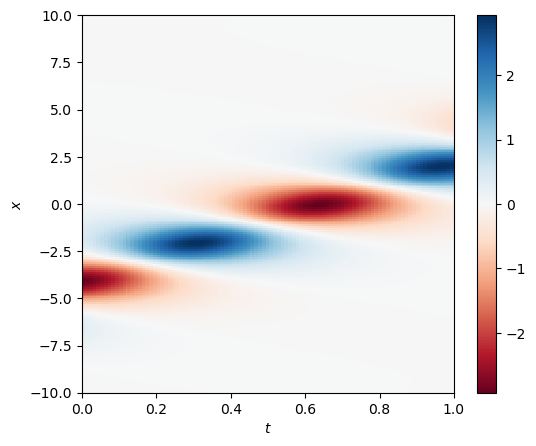

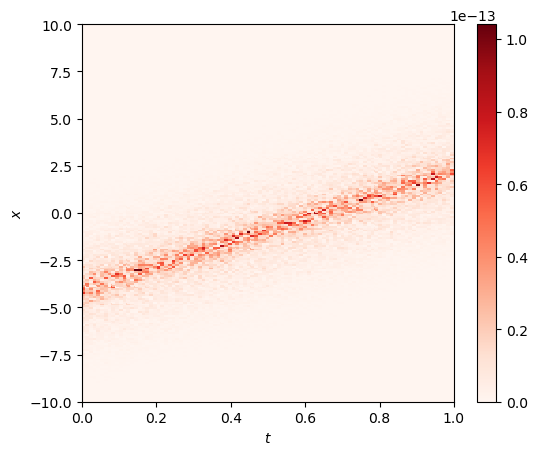

In [2]:
#старые параметры:
#параметры области:
'''x_0=-20
x_1=20
t_0=0
t_1=2
x_parts=200#400
t_parts=50#200
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
delta_x=x[1]-x[0]
delta_t=t[1]-t[0]
#задаваемые параметры уравнения и начального условия:
a1 = 1
a2 = 1
a4 = 0.3
a6 = 0.1
b1 = 1
k_param = 1 #!-!-! странная штука: если k!=1, то решение не подходит
khi = 1
a_param = 0.5
x0_param = 15
theta0 = math.pi/3'''

#новые параметры:
#параметры области:
x_0=-10
x_1=10
t_0=0
t_1=1
x_parts=200
t_parts=100
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
delta_x=x[1]-x[0]
delta_t=t[1]-t[0]
#задаваемые параметры уравнения и начального условия:
a1 = 1
a2 = -1
a4 = -0.3
a6 = 0.1
b1 = 6
k_param = 1 #!-!-! странная штука: если k!=1, то решение не подходит
khi = 1
a_param = 0.5
x0_param = 4
theta0 = math.pi/3


#определяемые параметры:
A1_param = (2*khi*(a2-6*a4*(k_param**2) + 12*a4*k_param + 10*a4 + 75*a6*(k_param**4) + 150*a6*(k_param**2) + 91*a6)/b1)**0.5
C0_param = a1 + 2*a2*k_param + 8*a4*(k_param**3) + 96*a6*(k_param**5)
w_param = a1*k_param + a2*(k_param**2) - a2 + 3*a4*(k_param**4) - 6*a4*(k_param**2) - a4 + 35*a6*(k_param**6) - 75*a6*(k_param**4) - 15*a6*(k_param**2) - a6
a3 = -4*a4*k_param - 40*a6*(k_param**3)
a5 = -6*a6*k_param
b2 = -(24*a4*(khi**2) + 360*a6*(khi**2)*(k_param**2) + 840*a6*(khi**2))/(A1_param**4)
b3 = 720*a6*(khi**3)/(A1_param**6)
print(f"a1 = {a1:.3f}, a2 = {a2:.3f}, a3 = {a3:.3f}, a4 = {a4:.3f}, a5 = {a5:.3f}, a6 = {a6:.3f},\n b1 = {b1:.3f}, b2 = {b2:.3f}, b3 = {b3:.3f}")


def q(x,t):
    frac = A1_param/(a_param*np.exp(x-C0_param*t+x0_param) + khi/(4*a_param*np.exp(x-C0_param*t+x0_param)))
    u = frac*np.cos(k_param*x-w_param*t+theta0)
    v = frac*np.sin(k_param*x-w_param*t+theta0)
    return u,v

def q_tensor(x,t):
    frac = A1_param/(a_param*torch.exp(x-C0_param*t+x0_param) + khi/(4*a_param*torch.exp(x-C0_param*t+x0_param)))
    u = frac*torch.cos(k_param*x-w_param*t+theta0)
    v = frac*torch.sin(k_param*x-w_param*t+theta0)
    return u,v

##chart
x = np.linspace(x_0, x_1, x_parts)
t = np.linspace(t_0, t_1, t_parts)
X, T = np.meshgrid(x, t)
U, V = q(X,T)
Q_abs = (U**2 + V**2)**0.5

fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=100)
ax.set(xlabel='$t$', ylabel='$x$')
c = ax.pcolormesh(T, X, U, cmap='RdBu')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)

##analytical solution accuracy
X_tensor = torch.tensor(X, requires_grad=True)
T_tensor = torch.tensor(T, requires_grad=True)
u, v = q_tensor(X_tensor, T_tensor)
#real part of derivatives
u_t = torch.autograd.grad(u,T_tensor,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
u_x = torch.autograd.grad(u,X_tensor,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
u_xx = torch.autograd.grad(u_x,X_tensor,grad_outputs=torch.ones_like(u_x),retain_graph=True,create_graph=True)[0]
u_3x = torch.autograd.grad(u_xx,X_tensor,grad_outputs=torch.ones_like(u_xx),retain_graph=True,create_graph=True)[0]
u_4x = torch.autograd.grad(u_3x,X_tensor,grad_outputs=torch.ones_like(u_3x),retain_graph=True,create_graph=True)[0]
u_5x = torch.autograd.grad(u_4x,X_tensor,grad_outputs=torch.ones_like(u_4x),retain_graph=True,create_graph=True)[0]
u_6x = torch.autograd.grad(u_5x,X_tensor,grad_outputs=torch.ones_like(u_5x),retain_graph=True,create_graph=True)[0]
#complex part of derivatives
v_t = torch.autograd.grad(v,T_tensor,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
v_x = torch.autograd.grad(v,X_tensor,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
v_xx = torch.autograd.grad(v_x,X_tensor,grad_outputs=torch.ones_like(v_x),retain_graph=True,create_graph=True)[0]
v_3x = torch.autograd.grad(v_xx,X_tensor,grad_outputs=torch.ones_like(v_xx),retain_graph=True,create_graph=True)[0]
v_4x = torch.autograd.grad(v_3x,X_tensor,grad_outputs=torch.ones_like(v_3x),retain_graph=True,create_graph=True)[0]
v_5x = torch.autograd.grad(v_4x,X_tensor,grad_outputs=torch.ones_like(v_4x),retain_graph=True,create_graph=True)[0]
v_6x = torch.autograd.grad(v_5x,X_tensor,grad_outputs=torch.ones_like(v_5x),retain_graph=True,create_graph=True)[0]

#i*q_t + i*a1*q_x + a2*q_xx + i*a3*q_3x + a4*q_4x + i*a5*q_5x + a6*q_6x + q*(b1*|q|**2 + b2*|q|**4 + b3*|q|**6) = 0
Real_Loss = -v_t - a1*v_x + a2*u_xx - a3*v_3x + a4*u_4x - a5*v_5x + a6*u_6x + u*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
Complex_Loss = u_t + a1*u_x + a2*v_xx + a3*u_3x + a4*v_4x + a5*u_5x + a6*v_6x + v*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
Loss = (Real_Loss**2 + Complex_Loss**2)**0.5

fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=100)
ax.set(xlabel='$t$', ylabel='$x$')
c = ax.pcolormesh(T, X, Loss.detach().numpy(), cmap='Reds')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)

In [3]:
!pip install pyDOE

In [4]:
from collections import OrderedDict #упорядоченный словарь
from pyDOE import lhs #функция, выбирающая значения для обучения на них нейросети
import time
np.random.seed(1234)

if torch.cuda.is_available(): #можно сменить среду выполнения на gpu и обучение будет происходить быстрее
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
class SinActivation(torch.nn.Module): #кастомная функция активации - sin
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

class DNN(torch.nn.Module): # нейросеть, в виде которой будет находиться решение
    def __init__(self, layers): #принимает на вход массив целых чисел
        super(DNN, self).__init__() #вызывает метод init(почему нельзя сделать это без super?)

        self.depth = len(layers) - 1
        self.activation = SinActivation #в качестве функции активации используется sin

        layer_list = list() #список с весами и функциями активации для каждого слоя
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])) #каждые два слоя образуют двудольный граф
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])) #нельзя сделать в цикле, потому что нет функции активации
        )

        layerDict = OrderedDict(layer_list) #сделали упорядоченный словарь, чтобы при использовании элементы выдавались в том порядке, в котором были добавлены

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) #задали архитектуру нейросети
    def forward(self, x):
        out = self.layers(x)
        return out

class PhysicsInformedNN(): # PINN
    def __init__(self, X_i, u, v, X_b, X_f, layers, lb, ub):

        # граничные условия
        self.lb = torch.tensor(lb).float().to(device) #нижнее
        self.ub = torch.tensor(ub).float().to(device) #верхнее

        # данные для обучения
        self.x_i = torch.tensor(X_i[:, 0:1], requires_grad=True).float().to(device) #для начальных условий: (x_i, t_i, u, v)
        self.t_i = torch.tensor(X_i[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.v = torch.tensor(v).float().to(device)
        self.x_b = torch.tensor(X_b[:, 0:1], requires_grad=True).float().to(device) #для граничных условий: (x_b, t_b)
        self.t_b = torch.tensor(X_b[:, 1:2], requires_grad=True).float().to(device)
        #self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device) #для уравнения: (x_f, t_f, f=0) (используются переданные сети точки)
        #self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 0:1], requires_grad=True).float().to(device) #создаём N_f точек для обучения соответствия уравнению. те, что переданы, не используем
        self.t_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 1:2], requires_grad=True).float().to(device)

        # модель
        self.layers = layers
        self.dnn = DNN(layers).to(device)

        # оптимизатор - LBFGS, обучает с точностью до 1e-5 или пока разница в точности уменьшается больше, чем точность float(?)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.005,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.adam = torch.optim.Adam(
          self.dnn.parameters(),
          lr=0.01,
          betas=(0.9, 0.999),
          eps=1e-08,
          weight_decay=0,
          amsgrad=False)

        self.iter = 0

    def net_uv(self, x, t): # вывод модели
        u = self.dnn(torch.cat([x, t], dim=1))[:,0:1]
        v = self.dnn(torch.cat([x, t], dim=1))[:,1:2]
        return u, v

    def net_f(self, x, t): #вывод  функции
        u, v = self.net_uv(x, t)
        #real part of derivatives
        u_t = torch.autograd.grad(u,t,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
        u_x = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),retain_graph=True,create_graph=True)[0]
        u_3x = torch.autograd.grad(u_xx,x,grad_outputs=torch.ones_like(u_xx),retain_graph=True,create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x,x,grad_outputs=torch.ones_like(u_3x),retain_graph=True,create_graph=True)[0]
        u_5x = torch.autograd.grad(u_4x,x,grad_outputs=torch.ones_like(u_4x),retain_graph=True,create_graph=True)[0]
        u_6x = torch.autograd.grad(u_5x,x,grad_outputs=torch.ones_like(u_5x),retain_graph=True,create_graph=True)[0]
        #complex part of derivatives
        v_t = torch.autograd.grad(v,t,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
        v_x = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x,x,grad_outputs=torch.ones_like(v_x),retain_graph=True,create_graph=True)[0]
        v_3x = torch.autograd.grad(v_xx,x,grad_outputs=torch.ones_like(v_xx),retain_graph=True,create_graph=True)[0]
        v_4x = torch.autograd.grad(v_3x,x,grad_outputs=torch.ones_like(v_3x),retain_graph=True,create_graph=True)[0]
        v_5x = torch.autograd.grad(v_4x,x,grad_outputs=torch.ones_like(v_4x),retain_graph=True,create_graph=True)[0]
        v_6x = torch.autograd.grad(v_5x,x,grad_outputs=torch.ones_like(v_5x),retain_graph=True,create_graph=True)[0]
        f_u = -v_t - a1*v_x + a2*u_xx - a3*v_3x + a4*u_4x - a5*v_5x + a6*u_6x + u*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
        f_v = u_t + a1*u_x + a2*v_xx + a3*u_3x + a4*v_4x + a5*u_5x + a6*v_6x + v*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
        return f_u, f_v

    def loss_func(self): #функция потерь
        self.optimizer.zero_grad() #обнуляет градиенты

        u_init, v_init = self.net_uv(self.x_i, self.t_i)
        u_bound, v_bound = self.net_uv(self.x_b, self.t_b)
        f_u_pred, f_v_pred = self.net_f(self.x_f, self.t_f)
        #учитываем начальные условия:
        loss_i = torch.mean(((self.u - u_init) ** 2 + (self.v - v_init) ** 2)/2)
        #граничные условия:
        u_x = torch.autograd.grad(u_bound,self.x_b,grad_outputs=torch.ones_like(u_bound),retain_graph=True,create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x,self.x_b,grad_outputs=torch.ones_like(u_x),retain_graph=True,create_graph=True)[0]
        v_x = torch.autograd.grad(v_bound,self.x_b,grad_outputs=torch.ones_like(v_bound),retain_graph=True,create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x,self.x_b,grad_outputs=torch.ones_like(v_x),retain_graph=True,create_graph=True)[0]
        loss_b = torch.mean((u_bound**2 + u_x**2 + u_xx**2 + v_bound**2 + v_x**2 + v_xx**2)/6)
        #loss_b = torch.mean((u_bound**2 + v_bound**2)/2)
        #уравнение:
        loss_f = torch.mean((f_u_pred**2 + f_v_pred**2)/2)

        loss = 10*loss_i + loss_b + loss_f

        loss.backward()
        self.iter += 1
        if self.iter % 1000 == 0:
            print('Iter %d, Loss: %.3e, Loss_i: %.2e, Loss_b: %.2e, Loss_f: %.2e' % (self.iter, loss.item(), loss_i.item(), loss_b.item(), loss_f.item()))
            loss_array.append(loss.item()) #loss запоминаем для графика
            iter_array.append(self.iter)

        if self.iter % 10 == 0: #каждые 10 итераций генерируем новые точки для обучения
          random_points = lb + (ub-lb)*lhs(2, N_f)
          self.x_f = torch.tensor(random_points[:, 0:1], requires_grad=True).float().to(device)
          self.t_f = torch.tensor(random_points[:, 1:2], requires_grad=True).float().to(device)

        return loss

    def train(self): #обучение
        adam_iterations = 100000
        print('training started')
        print('%d iterations of ADAM:' %adam_iterations)
        self.dnn.train()
        for i in range(adam_iterations): #во время тренировки производится 100000 шагов adam
            if i % 100 == 0: self.adam.param_groups[0]['lr'] = 0.993*self.adam.param_groups[0]['lr'] #экспоненциальное уменьшение шага каждые 100 шагов
            self.adam.step(self.loss_func)
        print('LBFGS:') #а дальше запускается lbfgs
        self.optimizer.step(self.loss_func)
        print('Total iterations: %d + %d' %(adam_iterations, (self.iter-adam_iterations)))


    def predict(self, X): #вывод нейросети и функции на входных данных
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u, v = self.net_uv(x, t)
        f_u, f_v = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v

In [6]:
N_u = 200 # число точек, обучающих принимать граничные значения
N_f = 10000 # число точек, обучающих удовлетворять уравнению
layers = [2, 100, 100, 100, 2] #2 входа, 2 выхода и 3 слоя по 100 нейронов
x = np.linspace(x_0, x_1, x_parts)
t = np.linspace(t_0, t_1, t_parts)
X, T = np.meshgrid(x, t)

Exact_q=q(X,T)[0] + 1j*q(X,T)[1]
Exact_u=np.real(Exact_q)
Exact_v=np.imag(Exact_q)
Exact_q_abs = np.abs(Exact_q)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# начальные условия
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
# граничные условия
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)

xx4 = np.hstack((X[-1:,:].T, T[-1:,:].T)) #(x,t_1)

X_uv_train = xx1
u_train = uu1
v_train = vv1
X_b_train = np.vstack([xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точках из области
X_f_train = np.vstack((X_f_train, np.vstack([xx1, xx2, xx3, xx4]))) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx,:]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
iter_array = [] #итерации с шагом 100

model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_b_train, X_f_train, layers, lb, ub)

In [7]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
100000 iterations of ADAM:
Iter 1000, Loss: 8.955e-02, Loss_i: 2.46e-03, Loss_b: 5.01e-04, Loss_f: 6.45e-02
Iter 2000, Loss: 4.917e-02, Loss_i: 7.51e-04, Loss_b: 1.85e-04, Loss_f: 4.15e-02
Iter 3000, Loss: 6.258e-02, Loss_i: 1.26e-03, Loss_b: 1.42e-04, Loss_f: 4.99e-02
Iter 4000, Loss: 4.568e-02, Loss_i: 8.78e-04, Loss_b: 2.01e-04, Loss_f: 3.67e-02
Iter 5000, Loss: 3.370e-02, Loss_i: 5.32e-04, Loss_b: 1.35e-04, Loss_f: 2.82e-02
Iter 6000, Loss: 2.700e-02, Loss_i: 2.81e-04, Loss_b: 6.75e-05, Loss_f: 2.41e-02
Iter 7000, Loss: 1.600e-02, Loss_i: 1.75e-04, Loss_b: 5.58e-05, Loss_f: 1.42e-02
Iter 8000, Loss: 1.441e-02, Loss_i: 2.86e-04, Loss_b: 6.01e-05, Loss_f: 1.15e-02
Iter 9000, Loss: 8.293e-03, Loss_i: 1.76e-04, Loss_b: 4.24e-05, Loss_f: 6.49e-03
Iter 10000, Loss: 1.683e-02, Loss_i: 2.78e-04, Loss_b: 3.93e-05, Loss_f: 1.40e-02
Iter 11000, Loss: 1.307e-02, Loss_i: 2.21e-04, Loss_b: 5.03e-05, Loss_f: 1.08e-02
Iter 12000, Loss: 4.694e-03, Loss_i: 8.06e-05, Loss_b: 2.46e-05

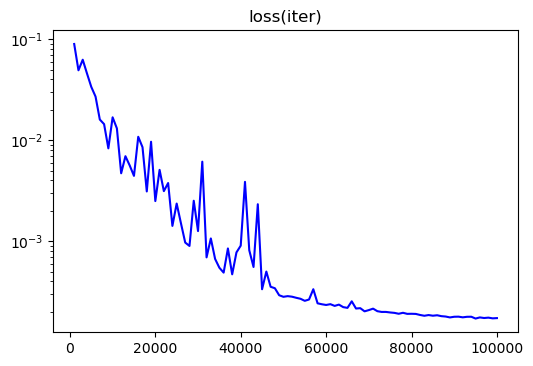

In [15]:
plt.rcParams['figure.dpi'] = 100
plt.plot(np.array(iter_array), np.array(loss_array), color = "blue")
#plt.ylim(0,5e-3)
plt.yscale("log")
plt.title('loss(iter)')
plt.show()

In [16]:
#torch.save(model, f'best_model.pth') #сохраняем модель
#model = torch.load(f'best_model.pth', map_location=device) #загружаем модель
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)

/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type SinActivation. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [ ]:
flatten_X = torch.reshape(X_tensor.float(),(x_parts*t_parts,1))
flatten_T = torch.reshape(T_tensor.float(),(x_parts*t_parts,1))
Real_Loss, Complex_Loss = model.net_f(flatten_X.to(device), flatten_T.to(device))
flatten_Loss = (Real_Loss**2 + Complex_Loss**2)**0.5
Loss = torch.reshape(flatten_Loss,(t_parts,x_parts))
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=100)
ax.set(xlabel='$t$', ylabel='$x$')
c = ax.pcolormesh(T, X, Loss.cpu().detach().numpy(), cmap='Reds')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)

<ipython-input-10-54466b607d59>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0,0].pcolormesh(T, X, Q_abs_truth, cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
<ipython-input-10-54466b607d59>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0,1].pcolormesh(T, X, U_truth, cmap='RdBu', vmin=u_min, vmax=u_max)
<ipython-input-10-54466b607d59>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is depreca

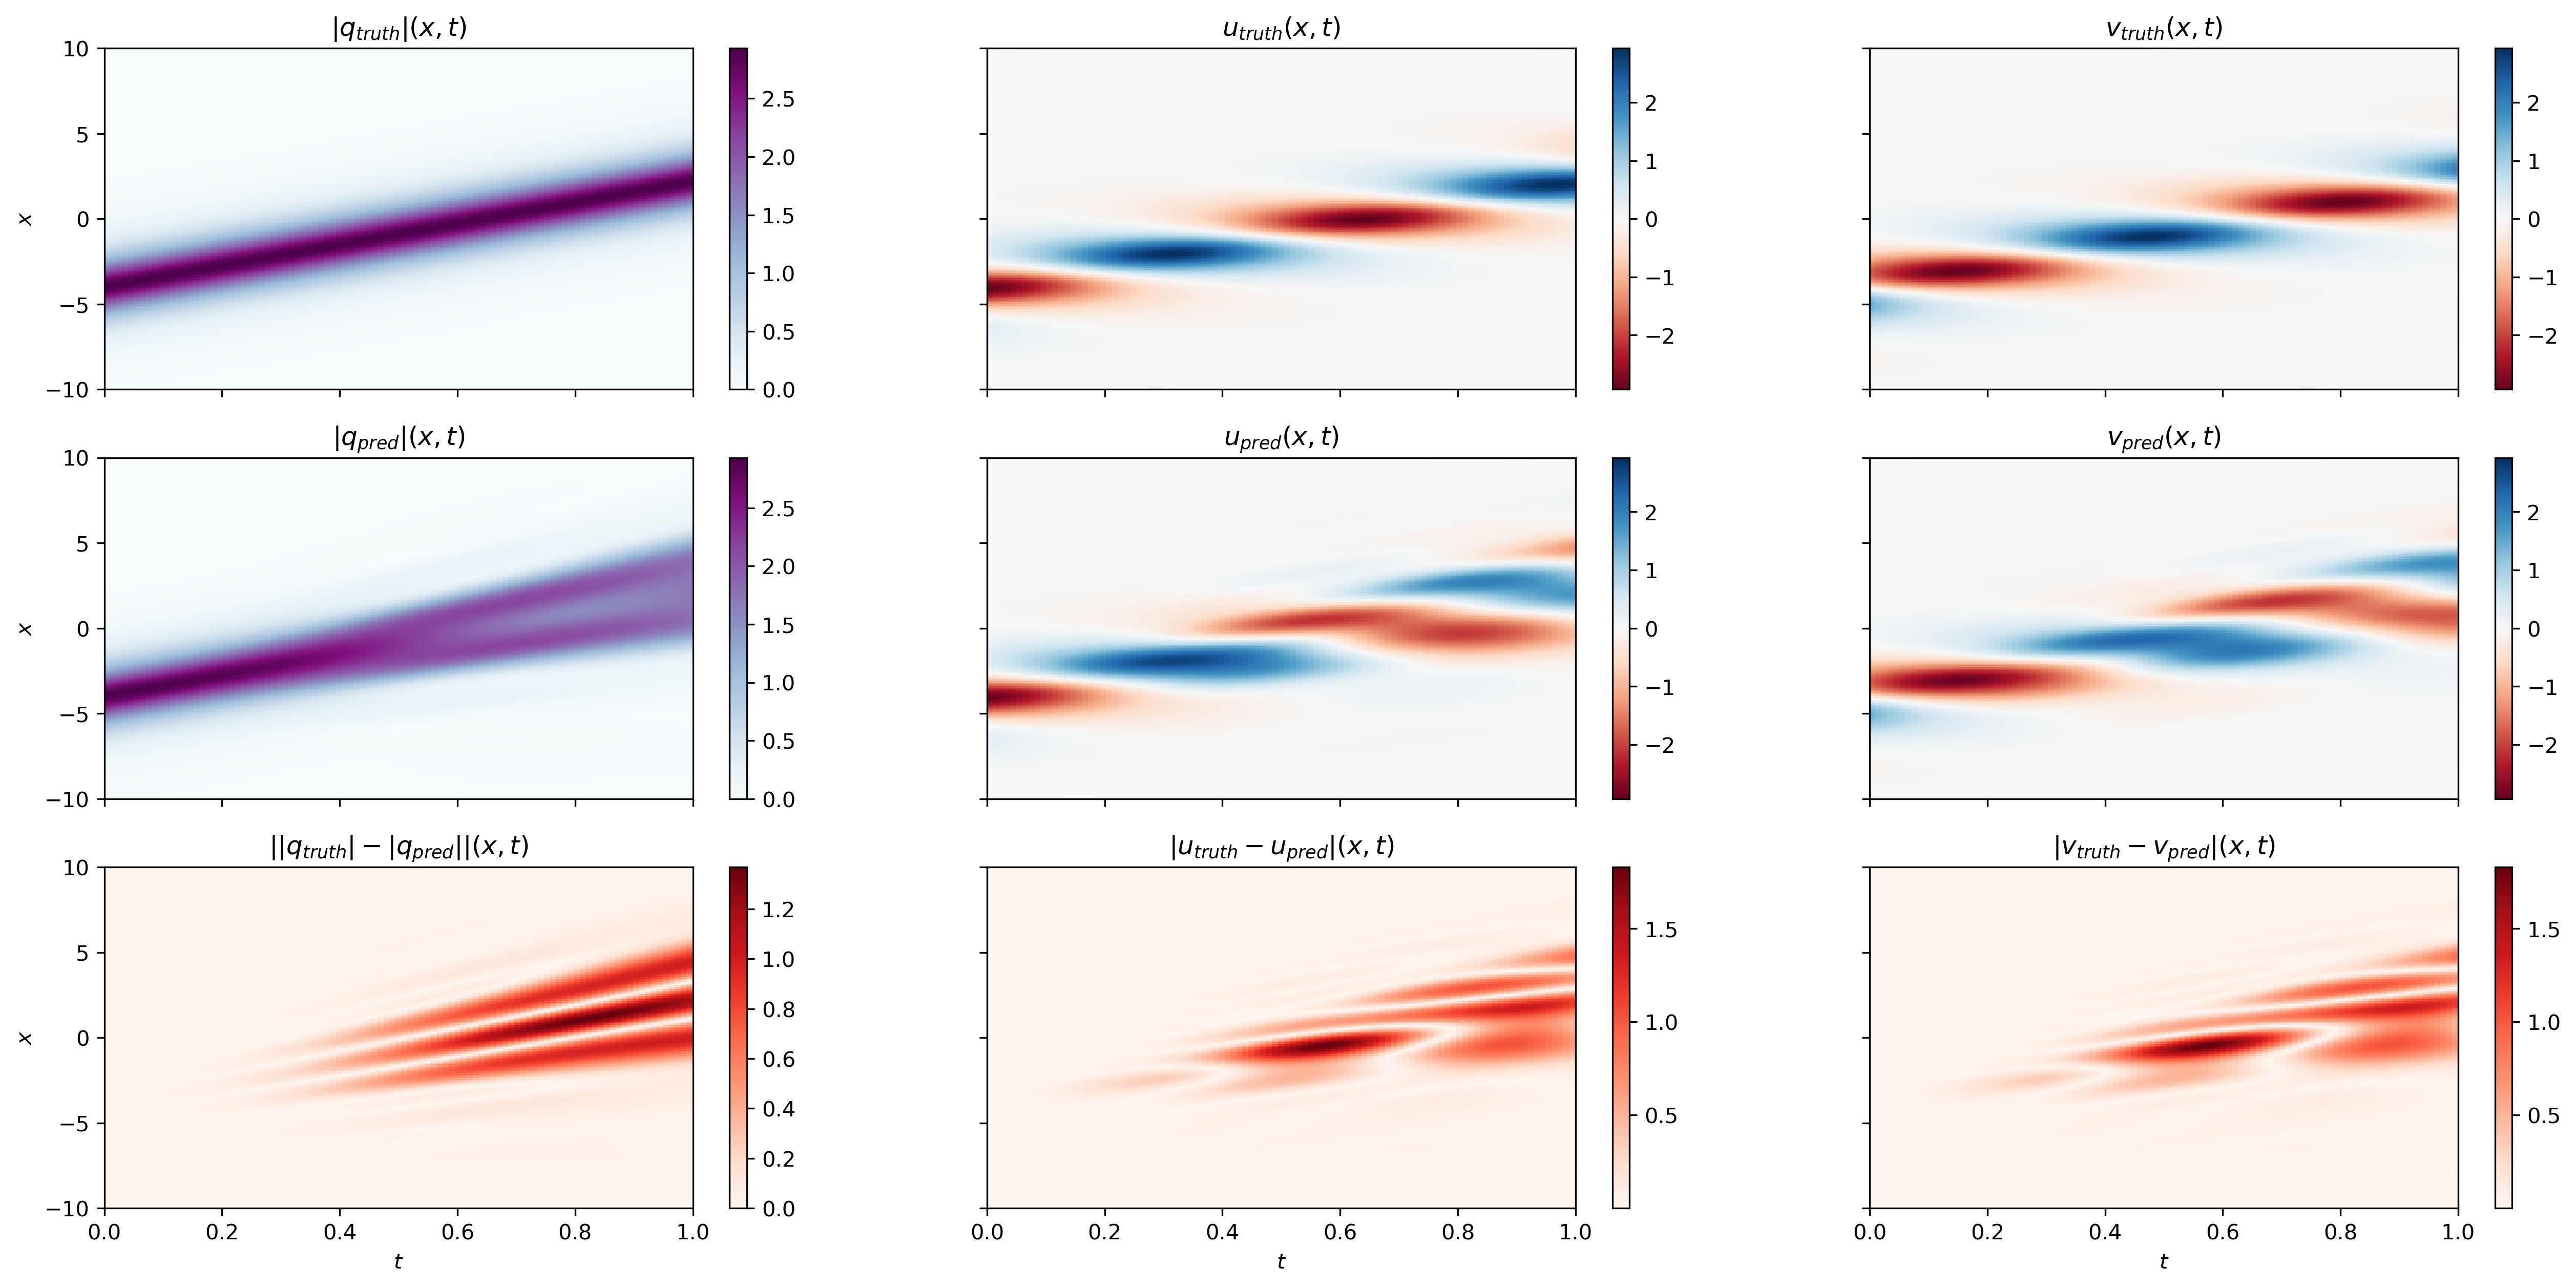

In [10]:
q_array=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
U_calc=np.real(q_array)
V_calc=np.imag(q_array)
Q_abs_calc=np.abs(q_array)

Q_truth=q(X,T)[0]+1j*q(X,T)[1]
U_truth=np.real(Q_truth)
V_truth=np.imag(Q_truth)
Q_abs_truth=np.abs(Q_truth)

fig, axs = plt.subplots(3, 3, figsize=(21,10), dpi=300)

for ax in axs.flat:
    ax.set(xlabel='$t$', ylabel='$x$')

for ax in axs.flat:
    ax.label_outer()

q_abs_min, q_abs_max = 0, np.abs(Q_abs_truth).max()
c = axs[0,0].pcolormesh(T, X, Q_abs_truth, cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
axs[0,0].set_title('$|q_{truth}|(x,t)$')
axs[0,0].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[0,0])

u_min, u_max = -np.abs(U_truth).max(), np.abs(U_truth).max()
c = axs[0,1].pcolormesh(T, X, U_truth, cmap='RdBu', vmin=u_min, vmax=u_max)
axs[0,1].set_title('$u_{truth}(x,t)$')
axs[0,1].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[0,1])

c = axs[0,2].pcolormesh(T, X, V_truth, cmap='RdBu', vmin=u_min, vmax=u_max)
axs[0,2].set_title('$v_{truth}(x,t)$')
axs[0,2].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[0,2])


#q_abs_min, q_abs_max = 0, np.abs(Q_abs_calc).max()
c = axs[1,0].pcolormesh(T, X, Q_abs_calc, cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
axs[1,0].set_title('$|q_{pred}|(x,t)$')
axs[1,0].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[1,0])

#u_min, u_max = -np.abs(U_calc).max(), np.abs(U_calc).max()
c = axs[1,1].pcolormesh(T, X, U_calc, cmap='RdBu', vmin=u_min, vmax=u_max)
axs[1,1].set_title('$u_{pred}(x,t)$')
axs[1,1].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[1,1])

c = axs[1,2].pcolormesh(T, X, V_calc, cmap='RdBu', vmin=u_min, vmax=u_max)
axs[1,2].set_title('$v_{pred}(x,t)$')
axs[1,2].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[1,2])


U_diff = np.abs(U_truth-U_calc)
V_diff = np.abs(U_truth-U_calc)
Q_abs_diff = np.abs(Q_abs_truth-Q_abs_calc)

q_abs_min, q_abs_max = 0, np.abs(Q_abs_diff).max()
c = axs[2,0].pcolormesh(T, X, Q_abs_diff, cmap='Reds', vmin=q_abs_min, vmax=q_abs_max)
axs[2,0].set_title('$||q_{truth}|-|q_{pred}||(x,t)$')
axs[2,0].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[2,0])

u_min, u_max = U_diff.min(), U_diff.max()
c = axs[2,1].pcolormesh(T, X, U_diff, cmap='Reds', vmin=u_min, vmax=u_max)
axs[2,1].set_title('$|u_{truth}-u_{pred}|(x,t)$')
axs[2,1].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[2,1])

c = axs[2,2].pcolormesh(T, X, V_diff, cmap='Reds', vmin=u_min, vmax=u_max)
axs[2,2].set_title('$|v_{truth}-v_{pred}|(x,t)$')
axs[2,2].axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=axs[2,2])

plt.savefig("neural_network_results.png")
plt.show()

In [11]:
#mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
#mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = np.mean((Q_abs_truth - Q_abs_calc)**2) #средний квадрат разности модулей
rel_h = np.linalg.norm(Q_abs_truth - Q_abs_calc, 2)/np.linalg.norm(Q_abs_truth, 2)
#mse_f_u = ((f_u_pred)**2).mean(axis=0).item() #средняя невязка на действительной части уравнения
#mse_f_v = ((f_v_pred)**2).mean(axis=0).item() #средняя невязка на мнимой части уравнения
print(f'MSE_q: {mse_q:.3e}, Rel_h: {rel_h:.3e}')

MSE_q: 7.959e-02, Rel_h: 2.801e-01
